# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists
import copy

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO, MaskablePPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT
from vimms_gym.experiments import preset_qcb_medium

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [5]:
env_alpha = 0.00
env_beta = 0.00
extract = True
params, max_peaks = preset_qcb_medium(None, alpha=env_alpha, beta=env_beta, extract_chromatograms=extract)
params, max_peaks

2023-03-21 10:26:16.307 | INFO     | vimms_gym.experiments:get_samplers:303 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_medium_extracted.p


({'chemical_creator': {'mz_range': (100, 600),
   'rt_range': (400, 800),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (200, 500),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7ff0eda91660>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7ff0efb1acb0>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7ff0efb37e50>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 600)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 800),
   'isolation_window': 0.7,
   'use_dew': False,
   'mz_tol': 10,
   'rt_tol': 5,
   'min_ms1_intensity': 5000,
   'alpha': 0.0,
   'beta': 0.0}},
 200)

In [6]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [7]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 200

dqn_in_dir = 'DQN_1.0E6'

# ppo_in_dir = os.path.join('..', '..', 'tune', 'QCB_resimulated_medium')
ppo_in_dir = 'PPO_10.0E6'

methods = [
    METHOD_RANDOM,
    METHOD_PPO,
    # METHOD_PPO_RECURRENT,
    # METHOD_DQN,        
    METHOD_TOPN,
]
valid_random = True
n_eval_episodes = 30

In [8]:
# topN parameters
topN_N = 10
topN_rt_tol = 5
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.5
ils = 0
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 15
weighteddew_N = 10

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

426
262
394
452
437
200
478
204
424
384
443
249
251
300
206
407
498
372
302
265
468
234
322
310
345
396
203
281
493
304


Generate new chemicals if not found

In [10]:
params['chemical_creator']

{'mz_range': (100, 600),
 'rt_range': (400, 800),
 'intensity_range': (10000.0, 1e+20),
 'n_chemicals': (200, 500),
 'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7ff0eda91660>,
 'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7ff0efb1acb0>,
 'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7ff0efb37e50>}

In [11]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    
    chemical_creator_params = params['chemical_creator']
    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [12]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [13]:
set_log_level_warning()

1

In [14]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7ff0eda91660>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7ff0efb1acb0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7ff0efb37e50>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.0,
  'beta': 0.0}}

In [15]:
horizon = 1
out_dir = 'evaluation_2.0E5_horizon_%d_alpha_%.2f_beta_%.2f' % (horizon, env_alpha, env_beta)

In [16]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)            
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN:
        
        fname = os.path.join(dqn_in_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, method, env_alpha, env_beta, horizon))
        # fname = os.path.join(dqn_in_dir, 'metric_reward_timesteps_1.0E6_alpha_%.2f_beta_%.2f' % (env_alpha, env_beta), method, 'best_model.zip')
        
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = env_alpha
        copy_params['env']['beta'] = env_beta                

    elif method == METHOD_PPO:
        
        fname = os.path.join(ppo_in_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, method, env_alpha, env_beta, horizon))
        # fname = os.path.join(ppo_in_dir, 'metric_reward_timesteps_1.0E5_alpha_%.2f_beta_%.2f' % (env_alpha, env_beta), method, 'best_model.zip')
        
        model = MaskablePPO.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = env_alpha
        copy_params['env']['beta'] = env_beta                
        
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params = dict(params)
            copy_params['env']['use_dew'] = True
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, 
                                                                                   copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method, horizon=horizon, valid_random=valid_random)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 200 N = 0 rt_tol = 5


Episode 0 (426 chemicals)
steps	 500 	total rewards	 330.0091057158588
steps	 1000 	total rewards	 694.9879754581491
steps	 1500 	total rewards	 1073.8600748646952
Finished after 1794 timesteps (2.451395273208618 seconds) with total reward 1282.6579011253712
{'coverage_prop': '0.946', 'intensity_prop': '0.682', 'ms1ms2_ratio': '0.130', 'efficiency': '0.254', 'TP': '327', 'FP': '76', 'FN': '23', 'precision': '0.811', 'recall': '0.934', 'f1': '0.869', 'total_rewards': 1282.6579011253684, 'invalid_action_count': 0, 'num_ms1_scans': 206, 'num_ms2_scans': 1588}

Episode 1 (262 chemicals)
steps	 500 	total rewards	 309.4468535834498
steps	 1000 	total rewards	 670.4902708341008
steps	 1500 	total rewards	 1019.6849181325161
Finished after 1707 timesteps (1.8728399276733398 seconds) with total reward 1177.8163424260422
{'coverage_prop': '0.947', 'intensity_prop': '0.758', 'ms1ms2_ratio': '0.207', 'efficiency': '0.175', 'TP': '225', 'FP': '23'

#### Test classic controllers in ViMMS

In [17]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [18]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7ff0eda91660>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7ff0efb1acb0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7ff0efb37e50>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': True,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.0,
  'beta': 0.0}}

In [19]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [20]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.960', 'intensity_prop': '0.746', 'ms1ms2_ratio': '0.215', 'efficiency': '0.293', 'TP': '366', 'FP': '43', 'FN': '17', 'precision': '0.895', 'recall': '0.956', 'f1': '0.924'}

Episode 1 finished
{'coverage_prop': '0.962', 'intensity_prop': '0.791', 'ms1ms2_ratio': '0.442', 'efficiency': '0.237', 'TP': '236', 'FP': '16', 'FN': '10', 'precision': '0.937', 'recall': '0.959', 'f1': '0.948'}

Episode 2 finished
{'coverage_prop': '0.970', 'intensity_prop': '0.750', 'ms1ms2_ratio': '0.273', 'efficiency': '0.295', 'TP': '344', 'FP': '38', 'FN': '12', 'precision': '0.901', 'recall': '0.966', 'f1': '0.932'}

Episode 3 finished
{'coverage_prop': '0.956', 'intensity_prop': '0.758', 'ms1ms2_ratio': '0.226', 'efficiency': '0.313', 'TP': '395', 'FP': '37', 'FN': '20', 'precision': '0.914', 'recall': '0.952', 'f1': '0.933'}

Episode 4 finished
{'coverage_prop': '0.975', 'intensity_prop': '0.759', 'ms1ms2_ratio': '0.234', 'efficiency': '0

Run SmartROI Controller

In [21]:
smartroi_N, smartroi_dew, alpha, beta, ils

(10, 5, 2, 0.5, 0)

In [22]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0, dew=smartroi_dew, initial_length_seconds=ils)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.979', 'intensity_prop': '0.703', 'ms1ms2_ratio': '0.802', 'efficiency': '0.543', 'TP': '356', 'FP': '61', 'FN': '9', 'precision': '0.854', 'recall': '0.975', 'f1': '0.910'}

Episode 1 finished
{'coverage_prop': '0.962', 'intensity_prop': '0.713', 'ms1ms2_ratio': '1.513', 'efficiency': '0.507', 'TP': '220', 'FP': '32', 'FN': '10', 'precision': '0.873', 'recall': '0.957', 'f1': '0.913'}

Episode 2 finished
{'coverage_prop': '0.970', 'intensity_prop': '0.708', 'ms1ms2_ratio': '0.850', 'efficiency': '0.516', 'TP': '324', 'FP': '58', 'FN': '12', 'precision': '0.848', 'recall': '0.964', 'f1': '0.903'}

Episode 3 finished
{'coverage_prop': '0.973', 'intensity_prop': '0.714', 'ms1ms2_ratio': '0.746', 'efficiency': '0.548', 'TP': '377', 'FP': '63', 'FN': '12', 'precision': '0.857', 'recall': '0.969', 'f1': '0.910'}

Episode 4 finished
{'coverage_prop': '0.991', 'intensity_prop': '0.723', 'ms1ms2_ratio': '0.779', 'efficiency':

Run WeightedDEW Controller

In [23]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.965', 'intensity_prop': '0.743', 'ms1ms2_ratio': '0.159', 'efficiency': '0.271', 'TP': '368', 'FP': '43', 'FN': '15', 'precision': '0.895', 'recall': '0.961', 'f1': '0.927'}

Episode 1 finished
{'coverage_prop': '0.958', 'intensity_prop': '0.791', 'ms1ms2_ratio': '0.242', 'efficiency': '0.186', 'TP': '238', 'FP': '13', 'FN': '11', 'precision': '0.948', 'recall': '0.956', 'f1': '0.952'}

Episode 2 finished
{'coverage_prop': '0.964', 'intensity_prop': '0.738', 'ms1ms2_ratio': '0.198', 'efficiency': '0.265', 'TP': '343', 'FP': '37', 'FN': '14', 'precision': '0.903', 'recall': '0.961', 'f1': '0.931'}

Episode 3 finished
{'coverage_prop': '0.969', 'intensity_prop': '0.762', 'ms1ms2_ratio': '0.158', 'efficiency': '0.288', 'TP': '404', 'FP': '34', 'FN': '14', 'precision': '0.922', 'recall': '0.967', 'f1': '0.944'}

Episode 4 finished
{'coverage_prop': '0.984', 'intensity_prop': '0.761', 'ms1ms2_ratio': '0.178', 'efficien

#### Plotting

Flatten data into dataframe

In [24]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,1282.657901,0.0,0.946,0.682,0.130,0.254,0.811,0.934,0.869
1,random,1177.816342,0.0,0.947,0.758,0.207,0.175,0.907,0.941,0.924
2,random,1273.698806,0.0,0.944,0.691,0.161,0.246,0.815,0.932,0.869
3,random,1262.011085,0.0,0.949,0.718,0.136,0.273,0.862,0.941,0.900
4,random,1203.666145,0.0,0.950,0.699,0.134,0.263,0.827,0.940,0.879


In [25]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

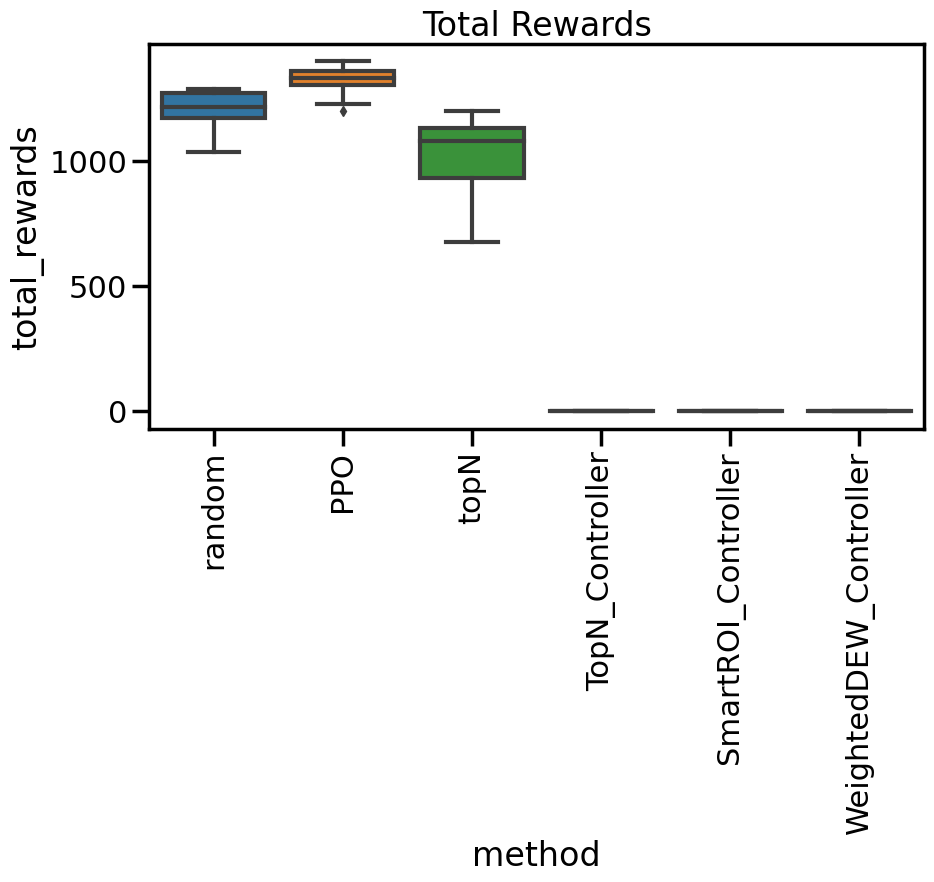

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

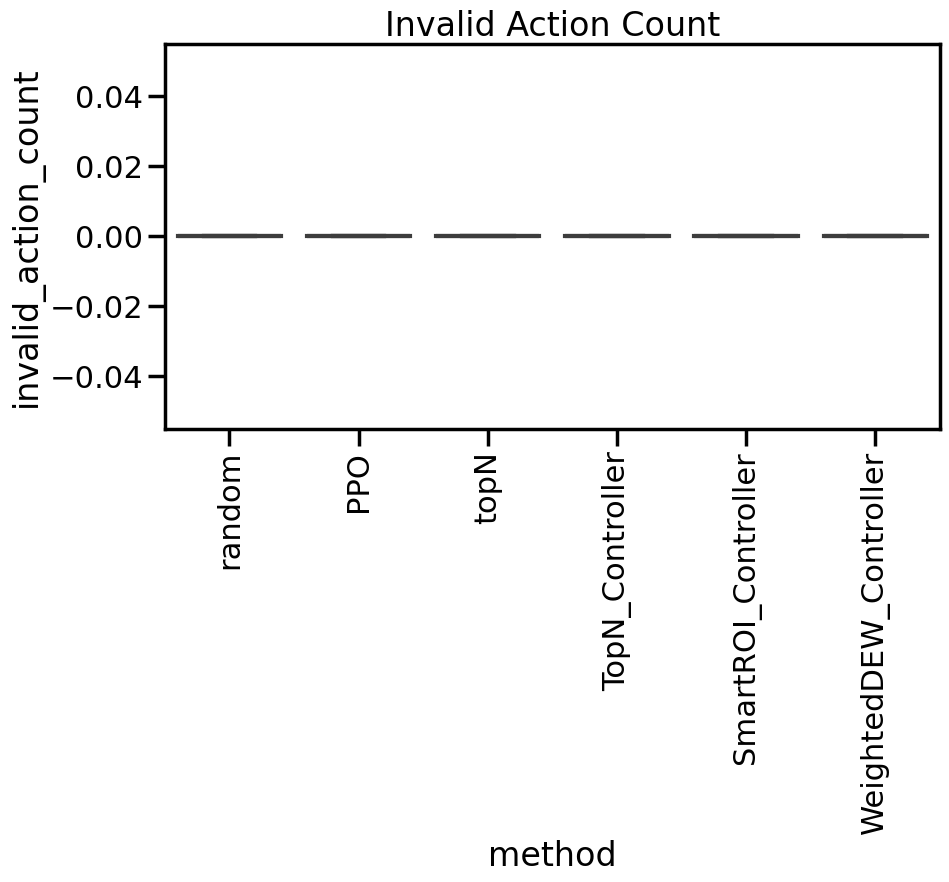

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

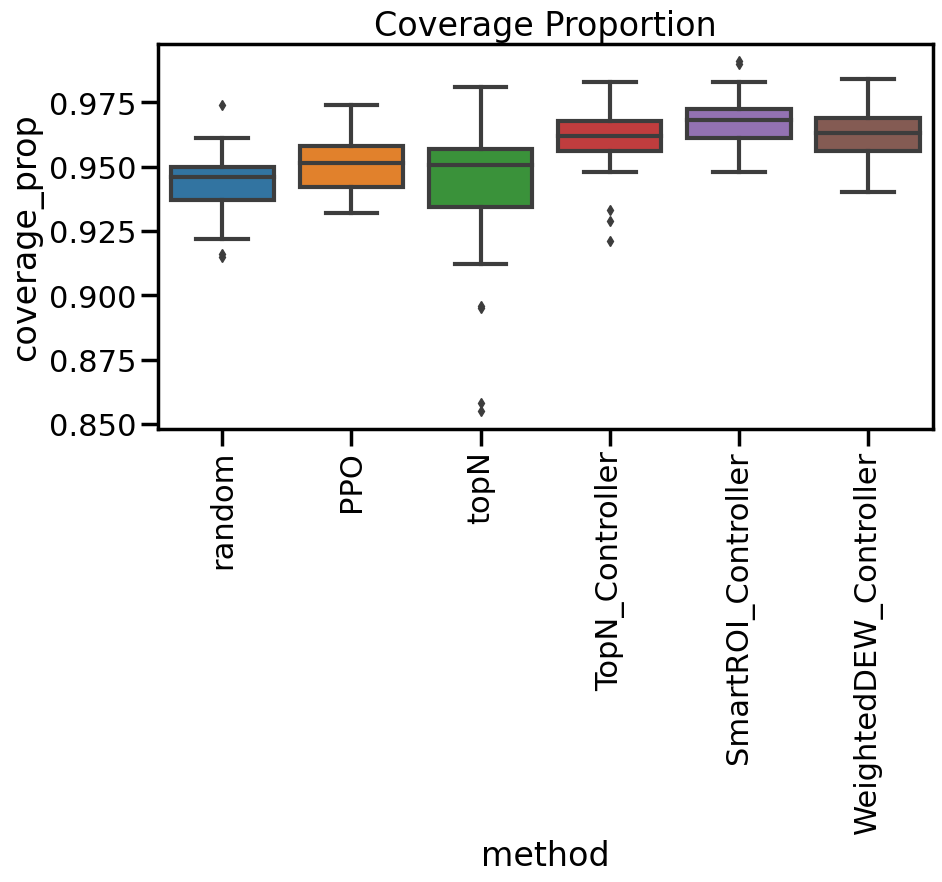

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

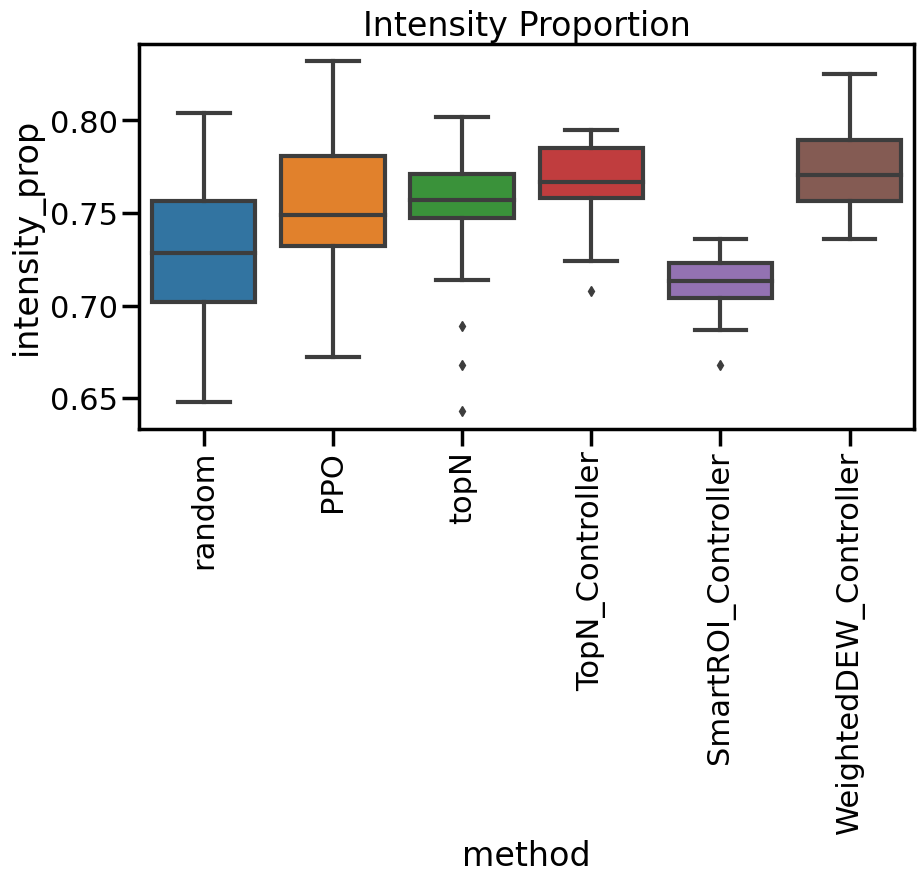

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

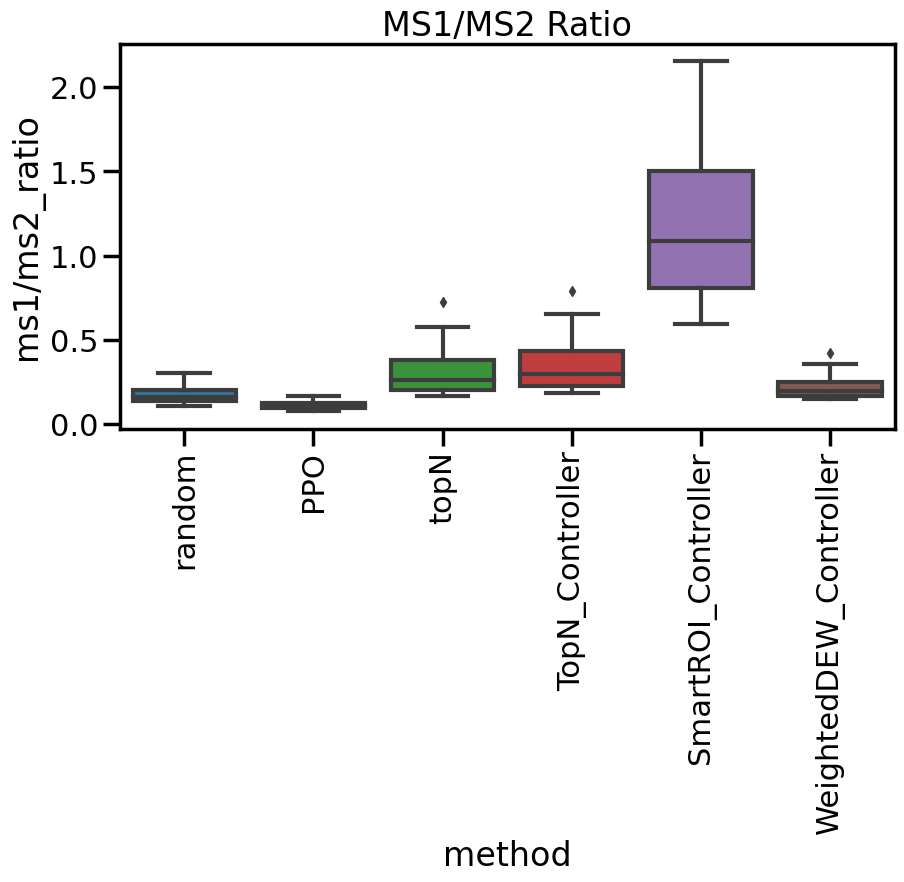

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

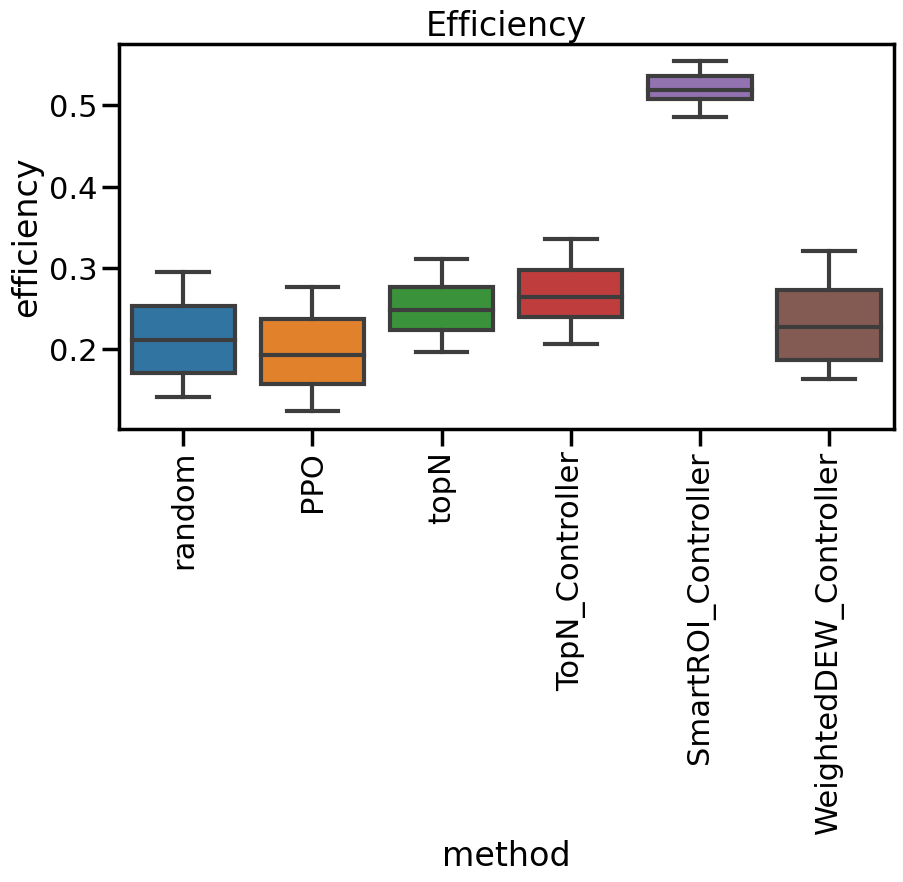

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

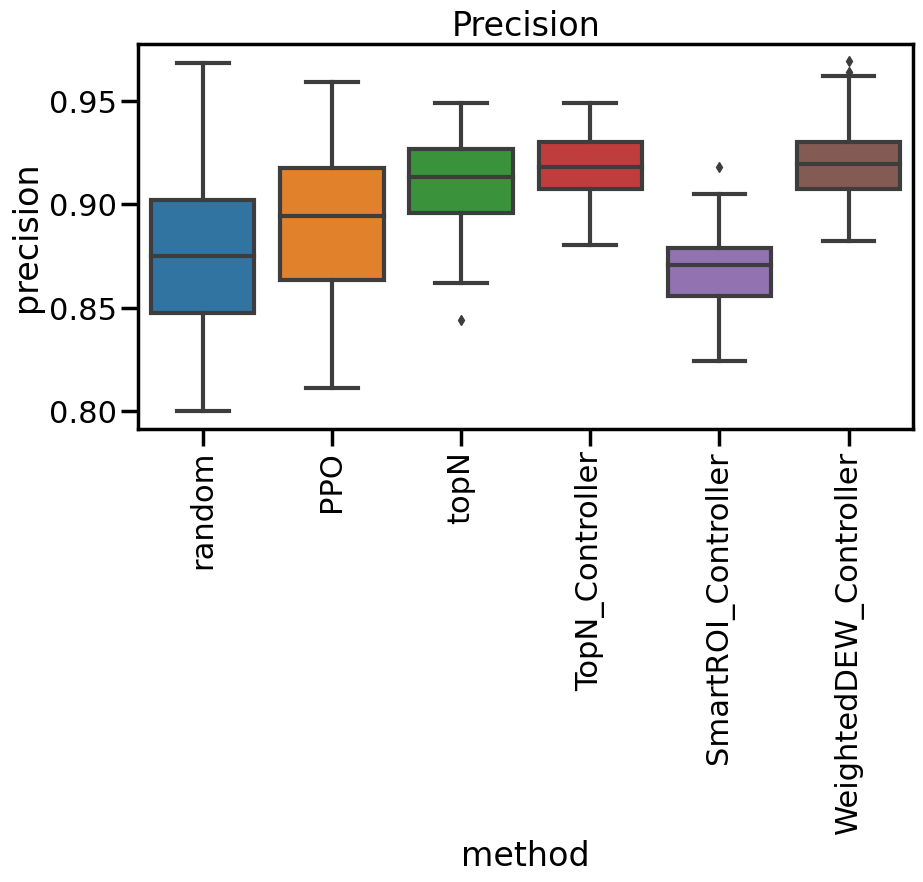

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

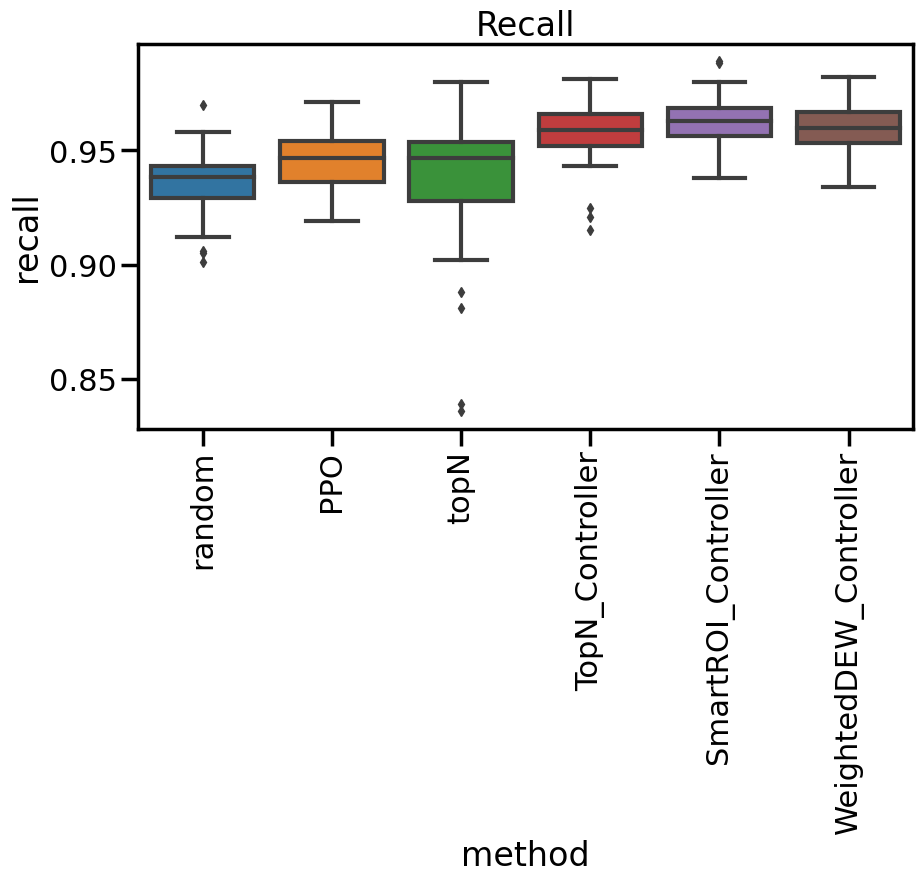

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

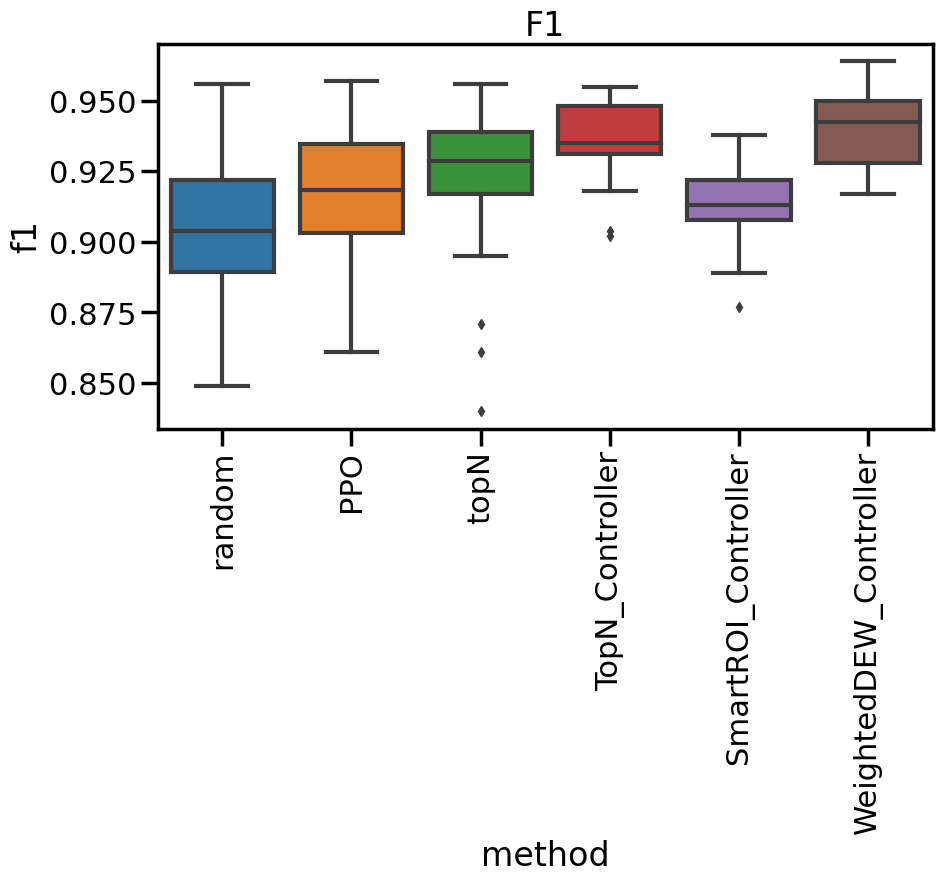

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [35]:
df.to_pickle('evaluation_2.0E5_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))

### Without 'random'

In [36]:
df = pd.read_pickle('evaluation_2.0E5_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))

In [37]:
new_df = df[df.method != 'random']
new_df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
30,PPO,1371.412598,0.0,0.944,0.724,0.089,0.237,0.881,0.937,0.908
31,PPO,1323.053294,0.0,0.954,0.790,0.130,0.157,0.928,0.951,0.939
32,PPO,1389.970811,0.0,0.959,0.733,0.107,0.229,0.865,0.953,0.907
33,PPO,1354.488099,0.0,0.958,0.735,0.093,0.257,0.868,0.952,0.908
34,PPO,1275.571162,0.0,0.961,0.732,0.099,0.251,0.855,0.955,0.902


Text(0.5, 1.0, 'Total Rewards')

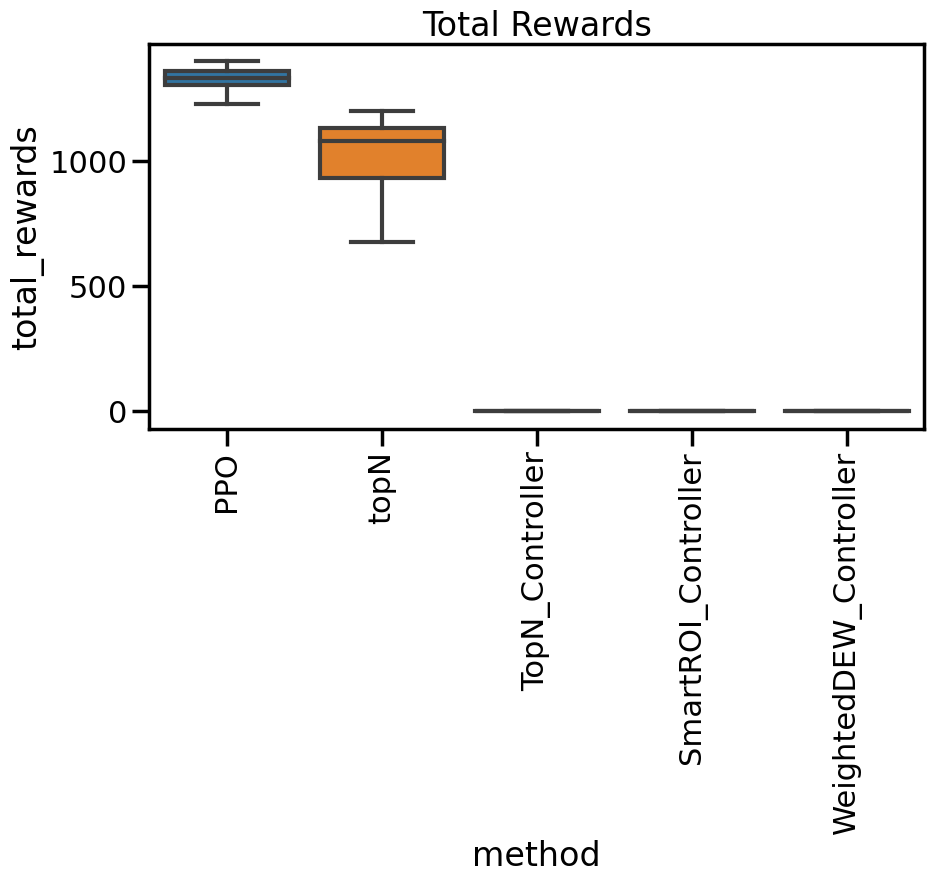

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='total_rewards', showfliers=False)
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

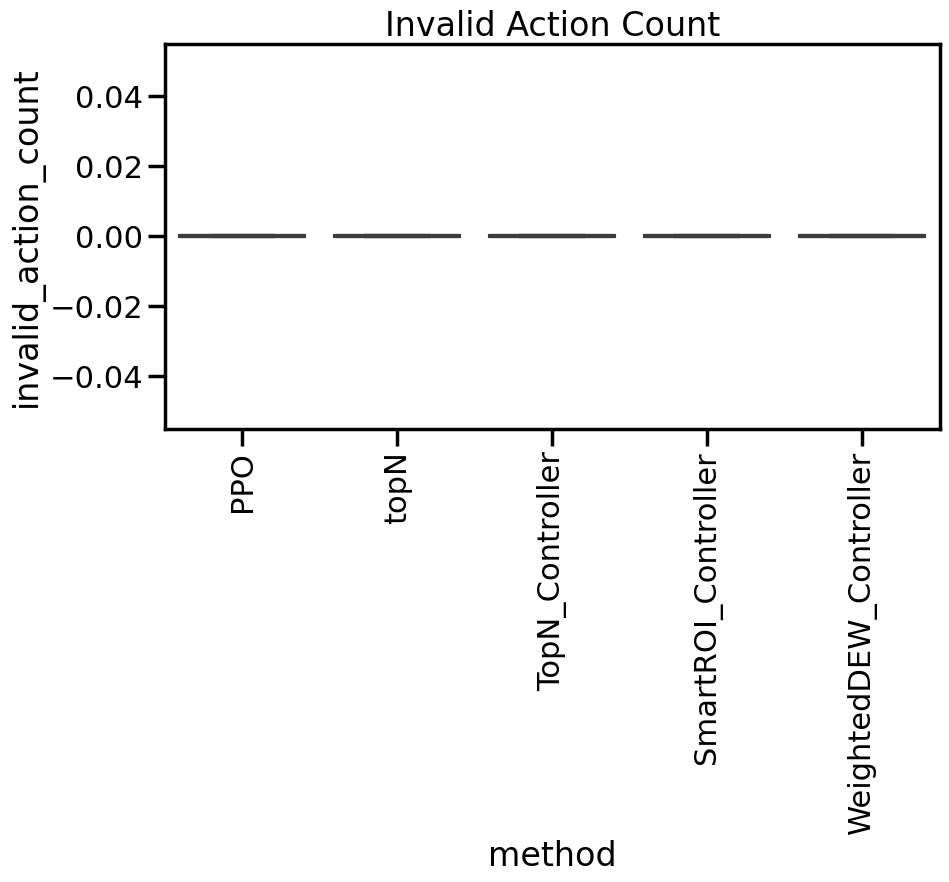

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='invalid_action_count', showfliers=False)
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

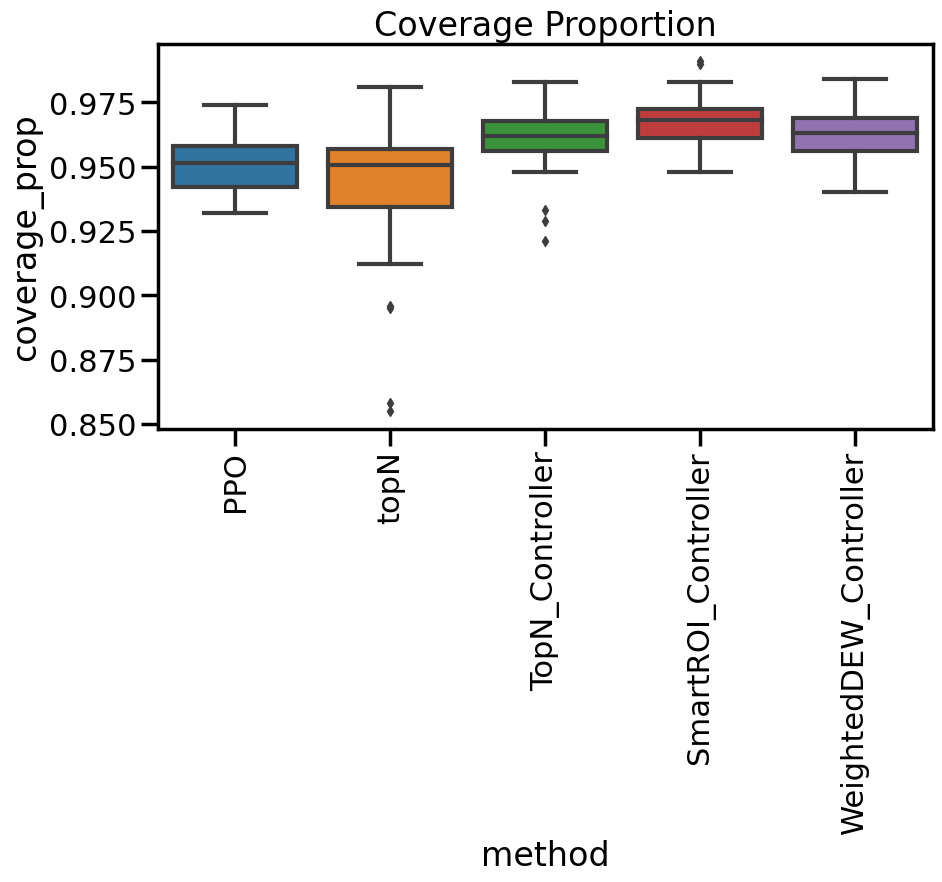

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

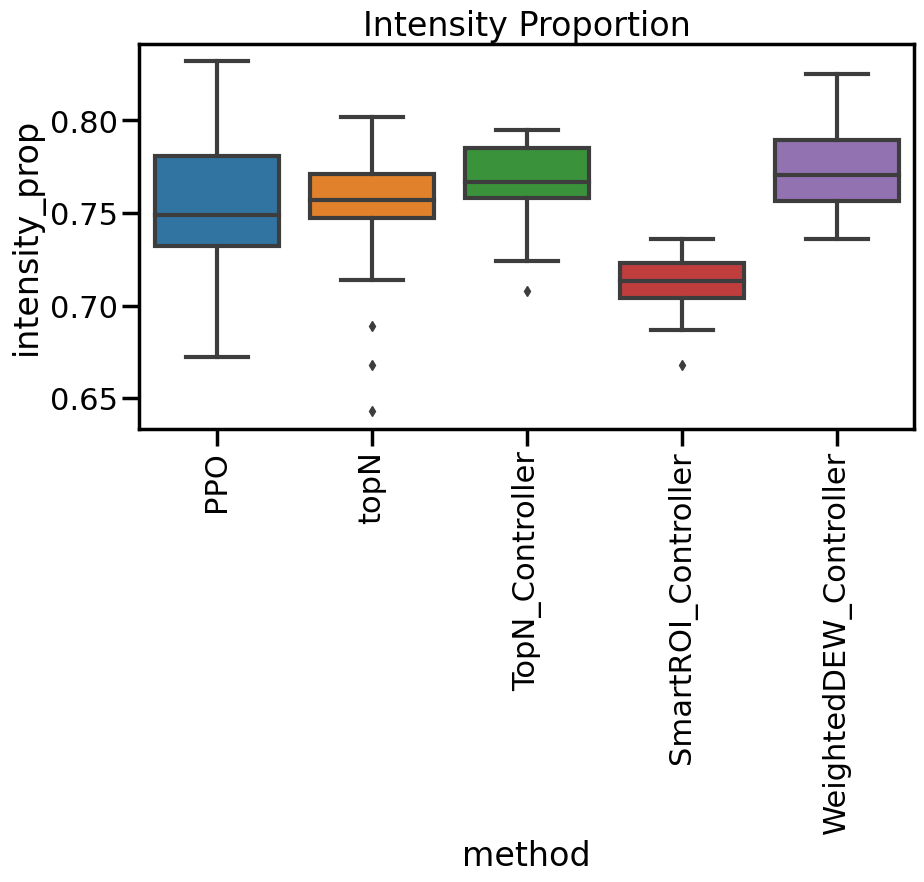

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

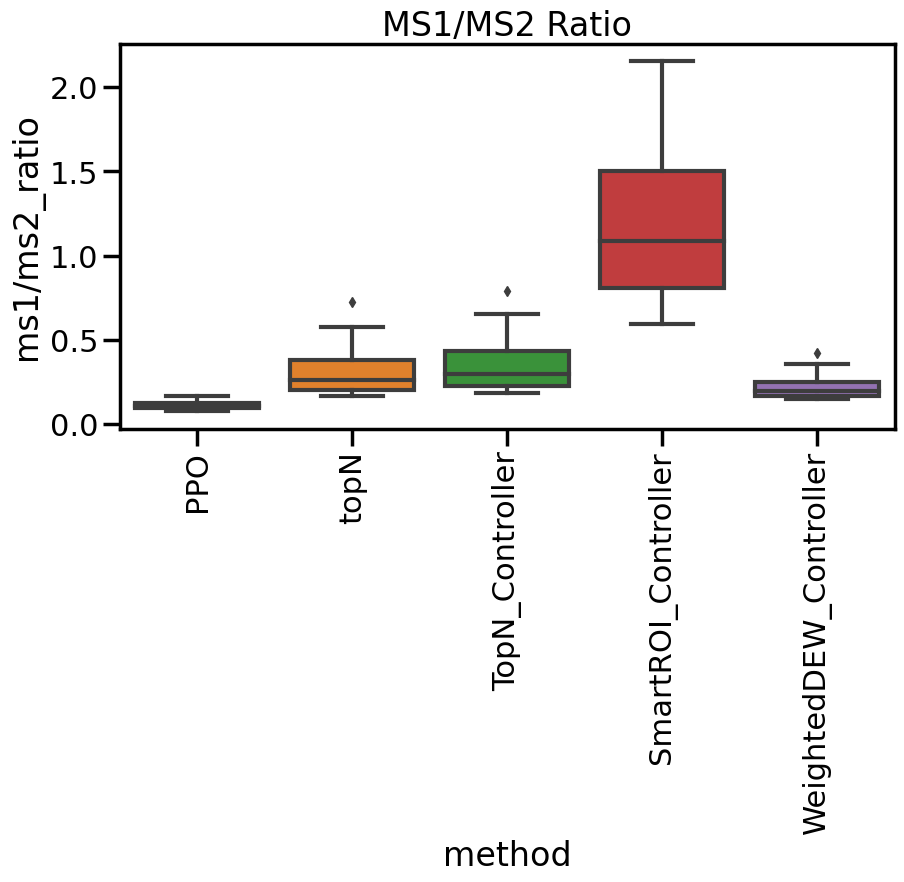

In [42]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

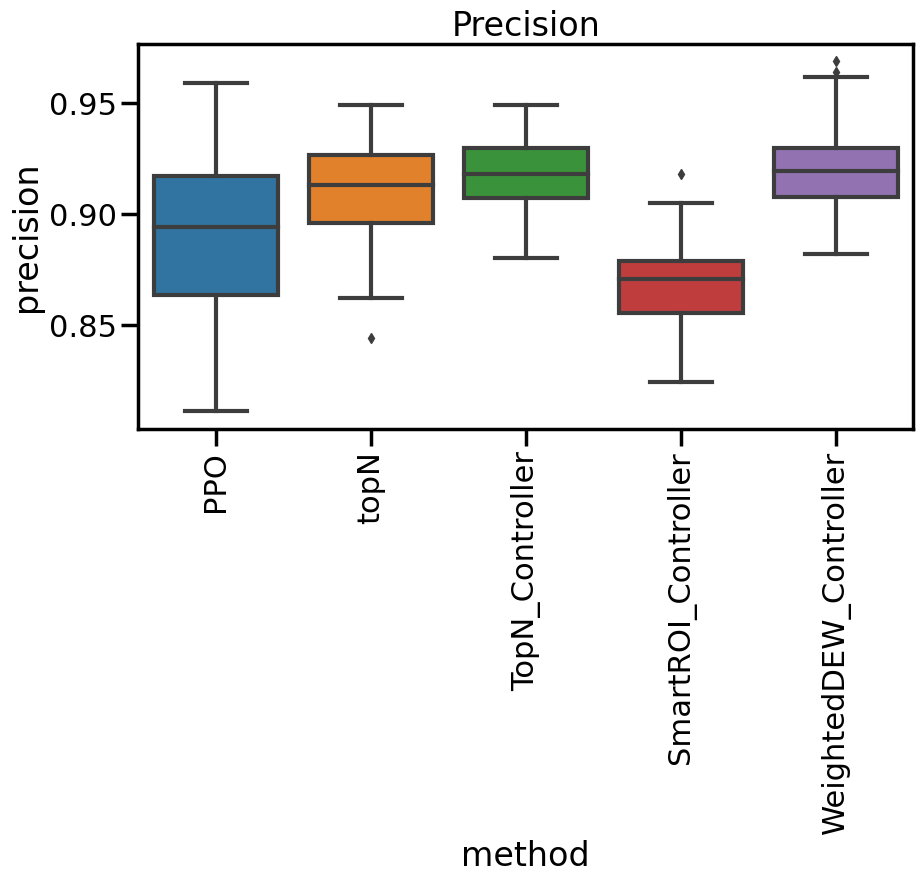

In [43]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

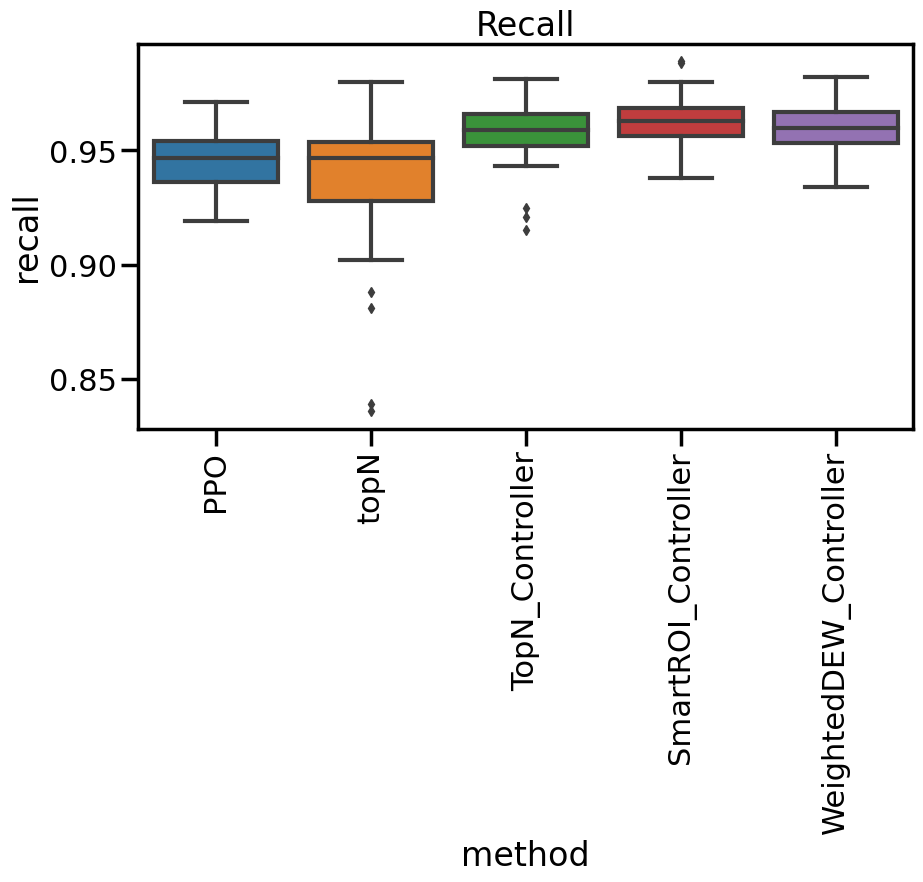

In [44]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

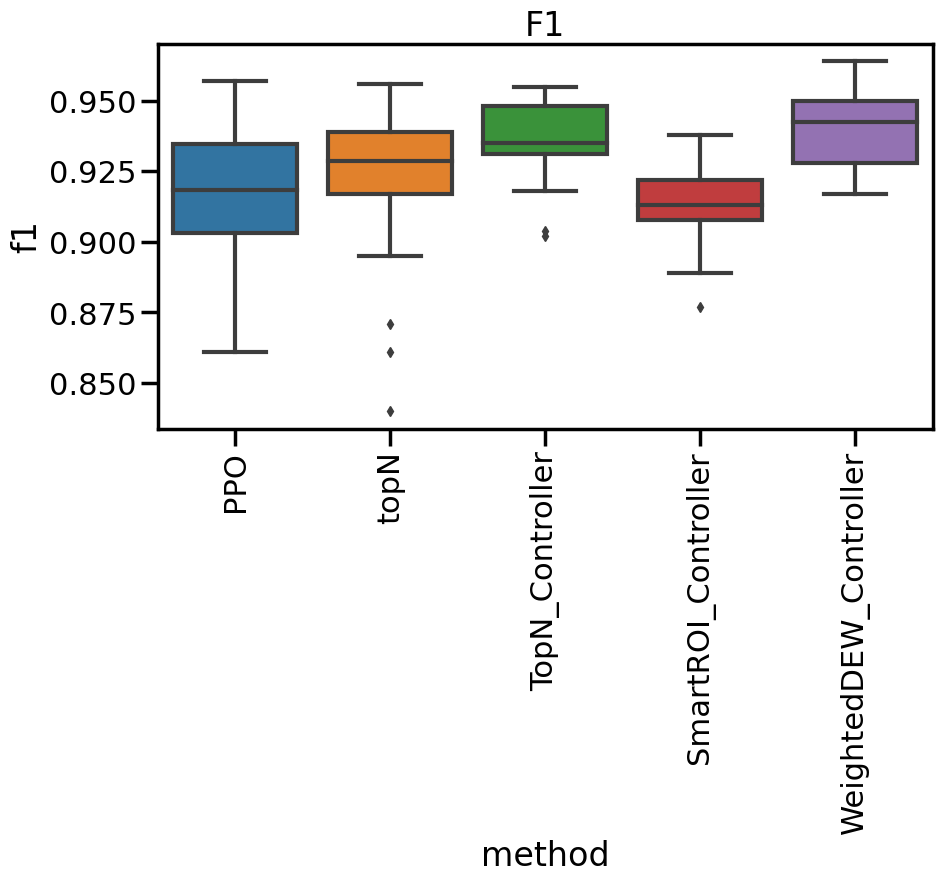

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')